In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../src/')

import torch
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np

from models.simple_LSTM import *
from models.train_model import train, k_fold
from models.early_stopping import EarlyStopping
from data.LSTM_dataset import LSTMDataset


i:\miniconda\envs\ml_project2\Lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] La procédure spécifiée est introuvable'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
c:\Users\ChauYing\Desktop\Projets\MA3\ml-project-2-ml-sonidito\notebook\../src\models\train_model.py:1: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [35]:
torch.manual_seed(0)

transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x : x.squeeze()),
        ])

features_selection = [0,1]
dataset = LSTMDataset('../data/dataset_pickle', '../data/MHD_labels/', features_selection, transform, max_length=4096)


data processing: 100%|██████████| 94/94 [01:16<00:00,  1.23it/s]


In [36]:
size = int(len(dataset) * 0.9)

train_set, test_set = torch.utils.data.random_split(dataset, [size, len(dataset)-size])

train_loader = torch.utils.data.DataLoader(train_set, batch_size=32)
val_loader = torch.utils.data.DataLoader(test_set, batch_size=32)
print(f'train size : {len(train_set)}, val size : {len(test_set)}')

train size : 84, val size : 10


In [38]:
input_size = dataset[0][0].shape[1]
print(f'input_size={input_size}')
hidden_size = 32
num_layers = 1
lr = 1e-3
weight_decay = 0 # 1e-4
l1_sigma = 1e-8

pos_weight = torch.tensor(3.2843) # size / # pos

model = SimpleLSTM(input_size, hidden_size, num_layers)
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay = weight_decay)
criterion = nn.BCEWithLogitsLoss(pos_weight)
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'The model has {num_params:,} trainable parameters')

patience=5
delta=5e-2
model_path = '../models/lstm.pt'
early_stopping = EarlyStopping(model_path, patience, delta)

print(model)    
print(optimizer)
print(criterion)
print(f'l1_sigma={l1_sigma}')
print(early_stopping)

input_size=2
The model has 5,281 trainable parameters
SimpleLSTM(
  (lstm): LSTM(2, 32, batch_first=True)
  (fc): Sequential(
    (0): Linear(in_features=32, out_features=16, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=16, out_features=8, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=8, out_features=1, bias=True)
  )
)
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)
BCEWithLogitsLoss()
l1_sigma=1e-08
EarlyStopping(
    patience : 5
    delta : 0.05
)


Epoch 25: 100%|██████████| 3/3 [00:00<00:00, 41.10batch/s, loss=1.21]


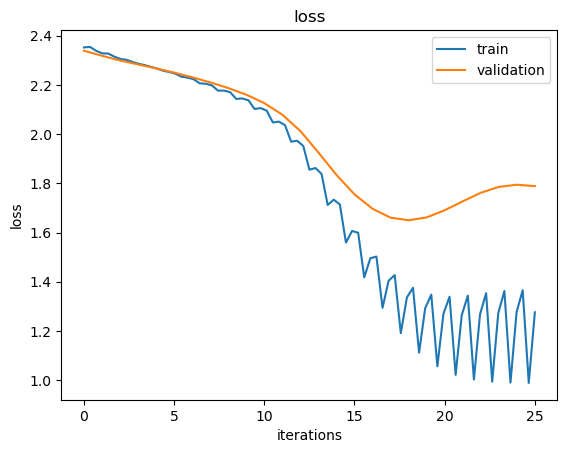

In [39]:
train(model, 
      train_loader, 
      val_loader, 
      optimizer, 
      criterion, 
      device, 
      n_epochs=500, 
      l1_sigma = l1_sigma,
      early_stopping=early_stopping)

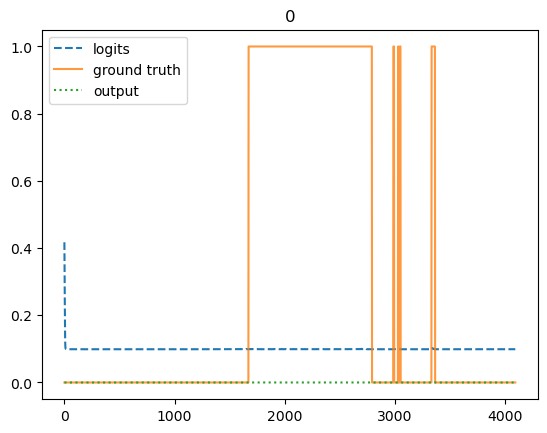

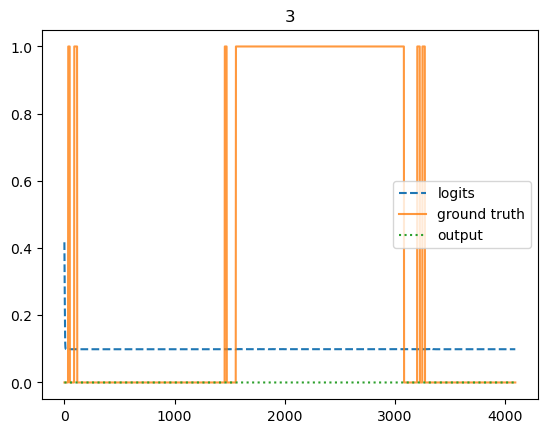

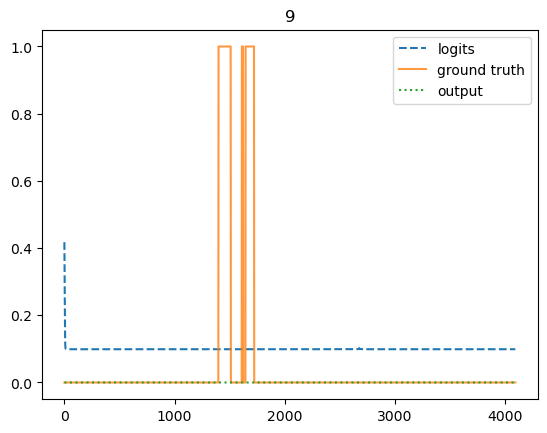

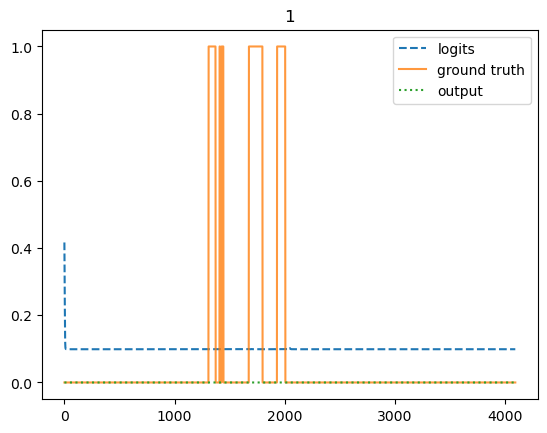

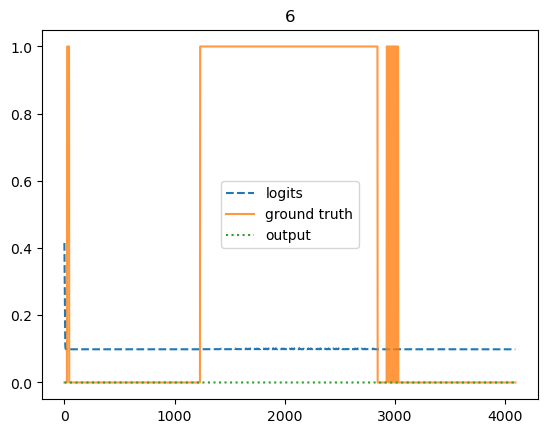

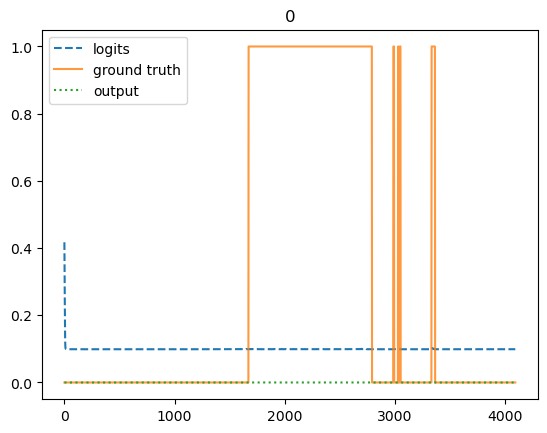

In [40]:
import numpy as np
import matplotlib.pyplot as plt

def create_output(logits, threshold=0.8):
    output = torch.zeros(logits.shape)
    for idx, logit in enumerate(logits):
        if (logit < threshold).all():
            continue

        start = torch.argmax((logit > threshold)* 1)
        end = len(logit) - torch.argmax(torch.flip(logit > threshold, dims=(0,)) * 1)

        res = torch.zeros(len(logit))
        res[start:end] = 1
        output[idx] = res

    return output

model.eval()
with torch.no_grad():
    for idx in np.random.choice(len(test_set), 6): 
        testing_data = test_set[idx]
        pred = torch.sigmoid(model(testing_data[0].to(device))).detach().cpu()
        plt.title(idx)
        plt.plot(pred.numpy(), label='logits', linestyle='--' )
        plt.plot(testing_data[1], label='ground truth', alpha=0.8)
        plt.plot(create_output(pred.unsqueeze(0)).squeeze(), label='output', linestyle=':')
        plt.legend()
        plt.show()

K-Fold

In [41]:
k = 4
n_epochs = 200

model = SimpleLSTM(input_size, hidden_size, num_layers)
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay = weight_decay)
criterion = nn.BCEWithLogitsLoss(pos_weight)

k_fold(dataset, model, criterion, device, lr, weight_decay,
       k, n_epochs, l1_sigma, batch_size=128, patience=patience, delta=delta)

100%|██████████| 4/4 [00:40<00:00, 10.06s/it]


{'accuracy': 0.21833834052085876,
 'precision': 0.0,
 'recall': nan,
 'f1': 0.0,
 'train_loss': 1.3753638869524,
 'val_loss': 1.3688662146776913}

# Grid Search

In [46]:
import json
from tqdm import tqdm

k = 4
n_epochs = 1

search_res = []

hyperparams = []
for hidden_size in [8,16,32]:
    for num_layers in [1,2]:
        for lr in [1e-2, 1e-3, 1e-4]:
            for weight_decay in [0, 1e-4, 1e-5]:
                for l1_sigma in [0, 1e-5, 1e-6, 1e-7] :
                    hyperparams.append({'hidden_size' : hidden_size,
                                        'num_layers': num_layers,
                                        'lr' : lr,
                                        'weight_decay' : weight_decay,
                                        'l1_sigma' : l1_sigma})
with tqdm(hyperparams) as pbar :    
    for hyperparam in pbar:
        hidden_size = hyperparam['hidden_size']
        num_layers = hyperparam['num_layers']
        lr = hyperparam['lr']
        weight_decay = hyperparam['weight_decay']
        l1_sigma = hyperparam['l1_sigma']

        model = SimpleLSTM(input_size, hidden_size, num_layers)
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay = weight_decay)
        criterion = nn.BCEWithLogitsLoss(pos_weight)

        metrics = k_fold(dataset, model, criterion, device, lr, weight_decay,
            k, n_epochs, l1_sigma, batch_size=128, patience=None, disable_pbar=True)

        pbar.set_postfix(hidden_size=hidden_size, num_layers=num_layers, lr=lr, weight_decay=weight_decay, l1_sigma=l1_sigma, f1=metrics["f1"])
        
        search_res.append({'hidden_size' : hidden_size,
                        'num_layers': num_layers,
                        'lr' : lr,
                        'weight_decay' : weight_decay,
                        'l1_sigma' : l1_sigma,
                        'metrics': metrics})
        
        with open('grid_search.json', 'w', encoding='utf-8') as f:
            json.dump(search_res, f, indent=4)

        pbar.update(1)

        del model
        del optimizer
        del criterion

  4%|▍         | 9/216 [00:10<04:10,  1.21s/it, f1=0, hidden_size=8, l1_sigma=1e-5, lr=0.01, num_layers=1, weight_decay=0.0001]